<a href="https://colab.research.google.com/github/niqolla/dmi_2/blob/main/I_Think_This_Works.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

    Import the necessary packages.

In [ ]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import scale, StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
import seaborn as sns
from sklearn.decomposition import PCA
from matplotlib.patches import Patch
from matplotlib_venn import venn2
from sklearn.manifold import TSNE

    Import the datasets.

In [ ]:
# read human data
human_data = pd.read_csv("/content/drive/MyDrive/datasets/human.gct", sep="\t", skiprows=2, )
mouse_data = pd.read_csv("/content/drive/MyDrive/datasets/mouse.txt",sep="\t")
rat_data = pd.read_csv("/content/drive/MyDrive/datasets/rat.txt",sep="\t")
species_ids = pd.read_csv("/content/drive/MyDrive/mart_ids.txt", sep="\t", na_values=[""])

In [ ]:
human_data = human_data.set_index('Name')

    In this block of code we're filtering so that we're only keeping the values of the columns specified in the Hands-on.

In [ ]:
to_keep = ["colon", "ileum", "duodenum", "jejunum", "small intestine" ,\
               "muscle", "pancreas", "liver", "stomach",  "kidney",  "quadriceps", \
               "thymus", "heart" , "esophagus", "brain", "gene_symbol_human"]

for i in human_data:
  if not any(cat in i.lower().split(' ') for cat in to_keep): 
               human_data.drop(columns=[i], inplace = True)

# Exercise 1

### PREPROCESSING

#### Scaling data

    These blocks of code start by saving the index of the original dataframe, so that it can later 
    reapplied to the new scaled dataframe. 
    The columns are then scaled so that they all have a mean 0 and a standard deviation of 1. 

    We also add a new "__SPECIES" string to the end of each of the comlumn names. 
    This is done also so there is a way to visually differentiate them once we do the 
    plotting of the heatmap.

In [ ]:
# SCALING MOUSE
mouse_index = mouse_data.index
scaler = StandardScaler()
mouse_data = pd.DataFrame(scaler.fit_transform(mouse_data), columns=mouse_data.columns+"___MOUSE")
mouse_data.index = mouse_index

In [ ]:
# SCALING RAT
rat_index = rat_data.index
scaler = StandardScaler()
rat_data = pd.DataFrame(scaler.fit_transform(rat_data), columns=rat_data.columns+"___RAT")
rat_data.index = rat_index

In [ ]:
# SCALING HUMAN
human_index = human_data.index
scaler = StandardScaler()
human_data = pd.DataFrame(scaler.fit_transform(human_data), columns=human_data.columns+"___HUMAN")
human_data.index = human_index

#### Removing dulicates

    We remove some duplicates to make sure that there is no redundant data.

In [ ]:
# REMOVING DUPLICATE ROWS
human_data.drop_duplicates(inplace=True)
mouse_data.drop_duplicates(inplace=True)
rat_data.drop_duplicates(inplace=True)

In [ ]:
# there are no duplicated columns
print(human_data.T.duplicated().sum())
print(mouse_data.T.duplicated().sum())
print(rat_data.T.duplicated().sum())

0
0
0


In [ ]:
print(human_data.shape)
print(mouse_data.shape)
print(rat_data.shape)

(38192, 27)
(34640, 39)
(24044, 40)


#### Organising tables

    In this step we take the data from the `mart_ids.txt` file. 
    It is a file which includes all the names of the different species. 
    Each of these names is then applied to the index of each of the 
    species to better identify the gene names.

In [ ]:
#### CREATING TABLE : index gene_symbol_human 	gene_symbol_mouse 	gene_symbol_rat
species_ids = species_ids.iloc[:, [1, 4, 5]]
species_ids = species_ids.dropna()
species_ids.columns = ["gene_symbol_human", "gene_symbol_mouse", "gene_symbol_rat"]

In [ ]:
#### CREATING TABLE : index || gene_symbol_mouse  |	199_1_Pancreas  |	 199_2_Liver  |	 199_3_Stomach .... (keeping only columns of interest)
human_data = human_data.reset_index().rename(columns={'Name':"gene_symbol_human"})

#### CREATING TABLE : gene_symbol_mouse 	199_1_Pancreas 	199_2_Liver 	199_3_Stomach ...
mouse_data = mouse_data.reset_index().rename(columns={'index': 'gene_symbol_mouse'})
# mouse_data

#### CREATING TABLE : gene_symbol_rat 	199_40_Pancreas 	199_41_Liver ....
rat_data = rat_data.reset_index().rename(columns={'index': 'gene_symbol_rat'})
# rat_data

In [ ]:
print('HUMAN\t----------------------------------------------------------------------------------------------------------')
display(human_data.head(3))
print('MOUSE\t----------------------------------------------------------------------------------------------------------')
display(mouse_data.head(3))
print('RAT\t----------------------------------------------------------------------------------------------------------')
display(rat_data.head(3))

HUMAN	----------------------------------------------------------------------------------------------------------


,gene_symbol_human,Brain - Amygdala___HUMAN,Brain - Anterior cingulate cortex (BA24)___HUMAN,Brain - Caudate (basal ganglia)___HUMAN,Brain - Cerebellar Hemisphere___HUMAN,Brain - Cerebellum___HUMAN,Brain - Cortex___HUMAN,Brain - Frontal Cortex (BA9)___HUMAN,Brain - Hippocampus___HUMAN,Brain - Hypothalamus___HUMAN,...,Esophagus - Muscularis___HUMAN,Heart - Atrial Appendage___HUMAN,Heart - Left Ventricle___HUMAN,Kidney - Cortex___HUMAN,Kidney - Medulla___HUMAN,Liver___HUMAN,Muscle - Skeletal___HUMAN,Pancreas___HUMAN,Small Intestine - Terminal Ileum___HUMAN,Stomach___HUMAN
0,ENSG00000223972.5,-0.021067,-0.022600,-0.022567,-0.038158,-0.035234,-0.024565,-0.026760,-0.020814,-0.022961,...,-0.038661,-0.024941,-0.021577,-0.021645,-0.025209,-0.028215,-0.030899,-0.022970,-0.035624,-0.029976
1,ENSG00000227232.5,-0.019289,-0.020369,-0.020514,-0.027047,-0.023602,-0.021058,-0.023432,-0.018762,-0.020570,...,-0.029286,-0.022688,-0.020404,-0.017946,-0.021908,-0.025102,-0.028260,-0.020444,-0.026077,-0.023897
2,ENSG00000243485.5,-0.021067,-0.022600,-0.022535,-0.038158,-0.035234,-0.024526,-0.026713,-0.020814,-0.022927,...,-0.038661,-0.024941,-0.021555,-0.021622,-0.025209,-0.028215,-0.030899,-0.022970,-0.035624,-0.029976


MOUSE	----------------------------------------------------------------------------------------------------------


,gene_symbol_mouse,199_1_Pancreas___MOUSE,199_2_Liver___MOUSE,199_3_Stomach___MOUSE,199_4_Duodenum___MOUSE,199_5_Jejunum___MOUSE,199_6_Ileum___MOUSE,199_7_Colon___MOUSE,199_8_Kidney___MOUSE,199_9_Quadriceps___MOUSE,...,199_30_Duodenum___MOUSE,199_31_Jejunum___MOUSE,199_32_Ileum___MOUSE,199_33_Colon___MOUSE,199_34_Kidney___MOUSE,199_35_Quadriceps___MOUSE,199_36_Thymus___MOUSE,199_37_Heart___MOUSE,199_38_Esophagus___MOUSE,199_39_Brain___MOUSE
0,ENSMUSG00000000001,-0.014148,0.100468,0.037376,0.352963,0.527822,0.475515,0.626422,0.130690,-0.011926,...,0.247006,0.498767,0.237501,0.528208,0.103836,-0.009230,1.347310,-0.000172,0.359503,0.077211
1,ENSMUSG00000000003,-0.018709,-0.055295,-0.021666,-0.081032,-0.086127,-0.059254,-0.121411,-0.048419,-0.039340,...,-0.075969,-0.088490,-0.040180,-0.120699,-0.044077,-0.034835,-0.185073,-0.039470,-0.088664,-0.130549
2,ENSMUSG00000000028,-0.018616,-0.052355,-0.017735,-0.056296,-0.057793,-0.018018,-0.033238,-0.042337,-0.034189,...,-0.050698,-0.042767,-0.020646,-0.063786,-0.041081,-0.030445,0.397206,-0.034466,-0.068726,-0.119410


RAT	----------------------------------------------------------------------------------------------------------


,gene_symbol_rat,199_40_Pancreas___RAT,199_41_Liver___RAT,199_42_Stomach___RAT,199_43_Duodenum___RAT,199_44_Jejunum___RAT,199_45_Ileum___RAT,199_46_Colon___RAT,199_47_Kidneys___RAT,199_48_Quadriceps___RAT,...,199_70_Jejunum___RAT,199_71_Ileum___RAT,199_72_Colon___RAT,199_73_Kidneys___RAT,199_74_Quadriceps___RAT,199_75_Thymus___RAT,199_76_Heart___RAT,199_77_Esophagus___RAT,199_78_Brain___RAT,199_79_Unknown___RAT
0,ENSRNOG00000000001,-0.023467,-0.055063,-0.022609,-0.066521,-0.077879,-0.064507,-0.061412,-0.062767,-0.044383,...,-0.079536,-0.114682,-0.079361,-0.051383,-0.041018,-0.155432,-0.037982,-0.075423,-0.085802,-0.015804
1,ENSRNOG00000000007,-0.023246,-0.055119,-0.023498,-0.067812,-0.079283,-0.067083,-0.067312,-0.062996,-0.044841,...,-0.081783,-0.127999,-0.087342,-0.051761,-0.041272,-0.155541,-0.037606,-0.080909,0.719405,0.222831
2,ENSRNOG00000000008,-0.023467,-0.055167,-0.023479,-0.067812,-0.079358,-0.067158,-0.068084,-0.063008,-0.044678,...,-0.082213,-0.128054,-0.088354,-0.051761,-0.041147,-0.154681,-0.038215,-0.081216,-0.079811,-0.015888


#### LEFT-Joining tables into one, on their gene_symbol

In [ ]:
# result = pd.merge(df1, df2, on='id', how='left')

result = pd.merge(species_ids, human_data, on='gene_symbol_human', how='left')
result = pd.merge(result, rat_data, on='gene_symbol_rat', how='left')
result = pd.merge(result, mouse_data, on='gene_symbol_mouse', how='left')

In [ ]:
result.dropna(how='any', inplace=True)

In [ ]:
result = result.set_index('gene_symbol_human').drop(columns=['gene_symbol_mouse','gene_symbol_rat'])

    Joining all the tables together. They're joined by their ENS IDs, and then 
    only the human homologues are kept. Then this column is set as the index
    because we will need to scale the data and we can't do that with strings 
    in the table.
    
    The reason why we choise the human IDs is primarily  because the 
    columns for the other species have gaps (NaN) values, and later we 
    remove all the rows with NaN values. So, if we keep the IDs for the 
    other species, possible filled rows will be deleted because of the 
    missing IDs.

    The final table has the human homologue as index and the as collumns: 
    "column title in original table" + "___SPECIES-NAME" 
    ex. 199_31_Jejunum___MOUSE

In [ ]:
result.head(4)

,Brain - Amygdala___HUMAN,Brain - Anterior cingulate cortex (BA24)___HUMAN,Brain - Caudate (basal ganglia)___HUMAN,Brain - Cerebellar Hemisphere___HUMAN,Brain - Cerebellum___HUMAN,Brain - Cortex___HUMAN,Brain - Frontal Cortex (BA9)___HUMAN,Brain - Hippocampus___HUMAN,Brain - Hypothalamus___HUMAN,Brain - Nucleus accumbens (basal ganglia)___HUMAN,...,199_30_Duodenum___MOUSE,199_31_Jejunum___MOUSE,199_32_Ileum___MOUSE,199_33_Colon___MOUSE,199_34_Kidney___MOUSE,199_35_Quadriceps___MOUSE,199_36_Thymus___MOUSE,199_37_Heart___MOUSE,199_38_Esophagus___MOUSE,199_39_Brain___MOUSE
gene_symbol_human,,,,,,,,,,,,,,,,,,,,,
ENSG00000198888.2,49.370068,50.072590,50.203824,51.246563,62.197652,62.458229,51.544141,48.152796,47.162908,48.377934,...,21.183656,23.961633,9.929593,36.798432,36.284879,23.808887,26.107956,79.601456,50.174989,73.688126
ENSG00000198763.3,46.534261,46.508987,62.939356,51.773810,54.724703,50.669004,49.497172,47.478791,50.191306,54.485132,...,11.530843,14.797360,4.830778,21.797259,32.195352,17.200224,15.908023,67.834669,53.019866,57.965821
ENSG00000198804.2,86.656608,87.448383,66.179781,63.249721,63.941197,97.900320,87.156281,85.228444,78.125519,65.629631,...,34.737841,39.583720,16.914932,77.497649,45.131620,25.109776,39.570742,119.285159,80.494703,96.613721
ENSG00000198938.2,89.506755,89.399628,70.755841,88.281820,81.433992,76.745828,82.756810,87.594886,87.408203,79.828204,...,-0.075969,-0.088490,-0.040180,-0.120699,-0.044077,-0.034835,-0.185073,-0.039470,-0.088664,-0.130549


In [ ]:
# Scaling RESULT
result_index = result.index
scaler = StandardScaler()
result = pd.DataFrame(scaler.fit_transform(result), columns=result.columns)
result.index = result_index 

In [ ]:
result.drop_duplicates(inplace=True)

In [ ]:
result = result.T

### Cluster tissues using gene expression data. Run k-means and hierarchical clustering. For each algorithm, determine the optimal number of clusters.

    When making decision for the number of clusers, we keep this 
    advice from ChatGPT in mind:  
    
    It's not uncommon to have different clustering evaluation metrics 
    suggesting different optimal numbers of clusters, especially if the 
    structure of the data is complex and/or there is no clear separation 
    between clusters.

    In general, the best number of clusters for a dataset is not a fixed number
    but rather a range or a set of possible clusterings, and different 
    evaluation metrics can give you different insights on the structure of the 
    data. Therefore, it's often a good idea to explore and compare the results 
    from different clustering algorithms and evaluation metrics, and to use 
    domain knowledge and intuition to select the most meaningful and 
    interpretable clustering.

    That being said, if you have to choose between the elbow method and the 
    silhouette coefficient, it's worth noting that the elbow method is more 
    straightforward and easier to interpret, as it looks for the point where 
    the rate of decrease in the sum of squared distances starts to level off. 
    However, it can also be influenced by the shape and scale of the data, and 
    it may not always identify the best number of clusters.

    The silhouette coefficient, on the other hand, is a more complex metric 
    that takes into account both the cohesion and separation of the clusters, 
    and it can be more robust to the shape and scale of the data. However, it's 
    also more computationally intensive and may not always be intuitive to 
    interpret.

    In summary, both methods have their advantages and limitations, and it's 
    often a good idea to use both and see if they agree or disagree on the 
    optimal number of clusters, and to explore and compare the resulting 
    clusterings using other visualization and evaluation techniques.

#### 1) K-MEANS

##### A) ELBOW TEST

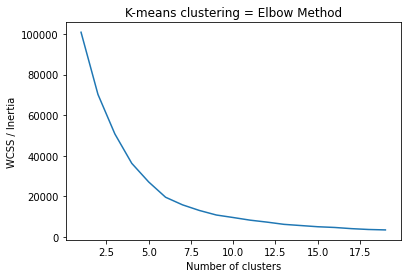

In [ ]:
wcss = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=0)
    kmeans.fit(result)
    wcss.append(kmeans.inertia_)

# plot the WCSS values for different values of k
plt.plot(range(1, 20), wcss)
plt.title('K-means clustering = Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS / Inertia')
plt.show()

      --> Elbow : we could say that around 6 or 7 clusters we might get the optimal amount of clusters.

##### B) SILHOUETTE TEST

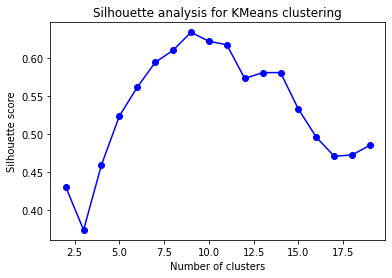

In [ ]:
# specify the range of k values to test
k_range = range(2, 20)

# calculate the silhouette scores for each k value
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k)
    cluster_labels = kmeans.fit_predict(result)
    silhouette_scores.append(silhouette_score(result, cluster_labels))

# plot the silhouette scores as a function of k
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis for KMeans clustering')
plt.show()


      --> Silhouette : In this case, we find that the optimal amount of clusters seems to be 9.

    These two results are a bit strange. I would say that we should keep the silhouette scores amount of 
    clusters rather than the elbow. Since here we actually have a clearer result, rather than the 
    elbow which is a lot more ambiguous.

#### 2) HIERARCHICAL CLUSTERING

<Figure size 1800x1200 with 0 Axes>

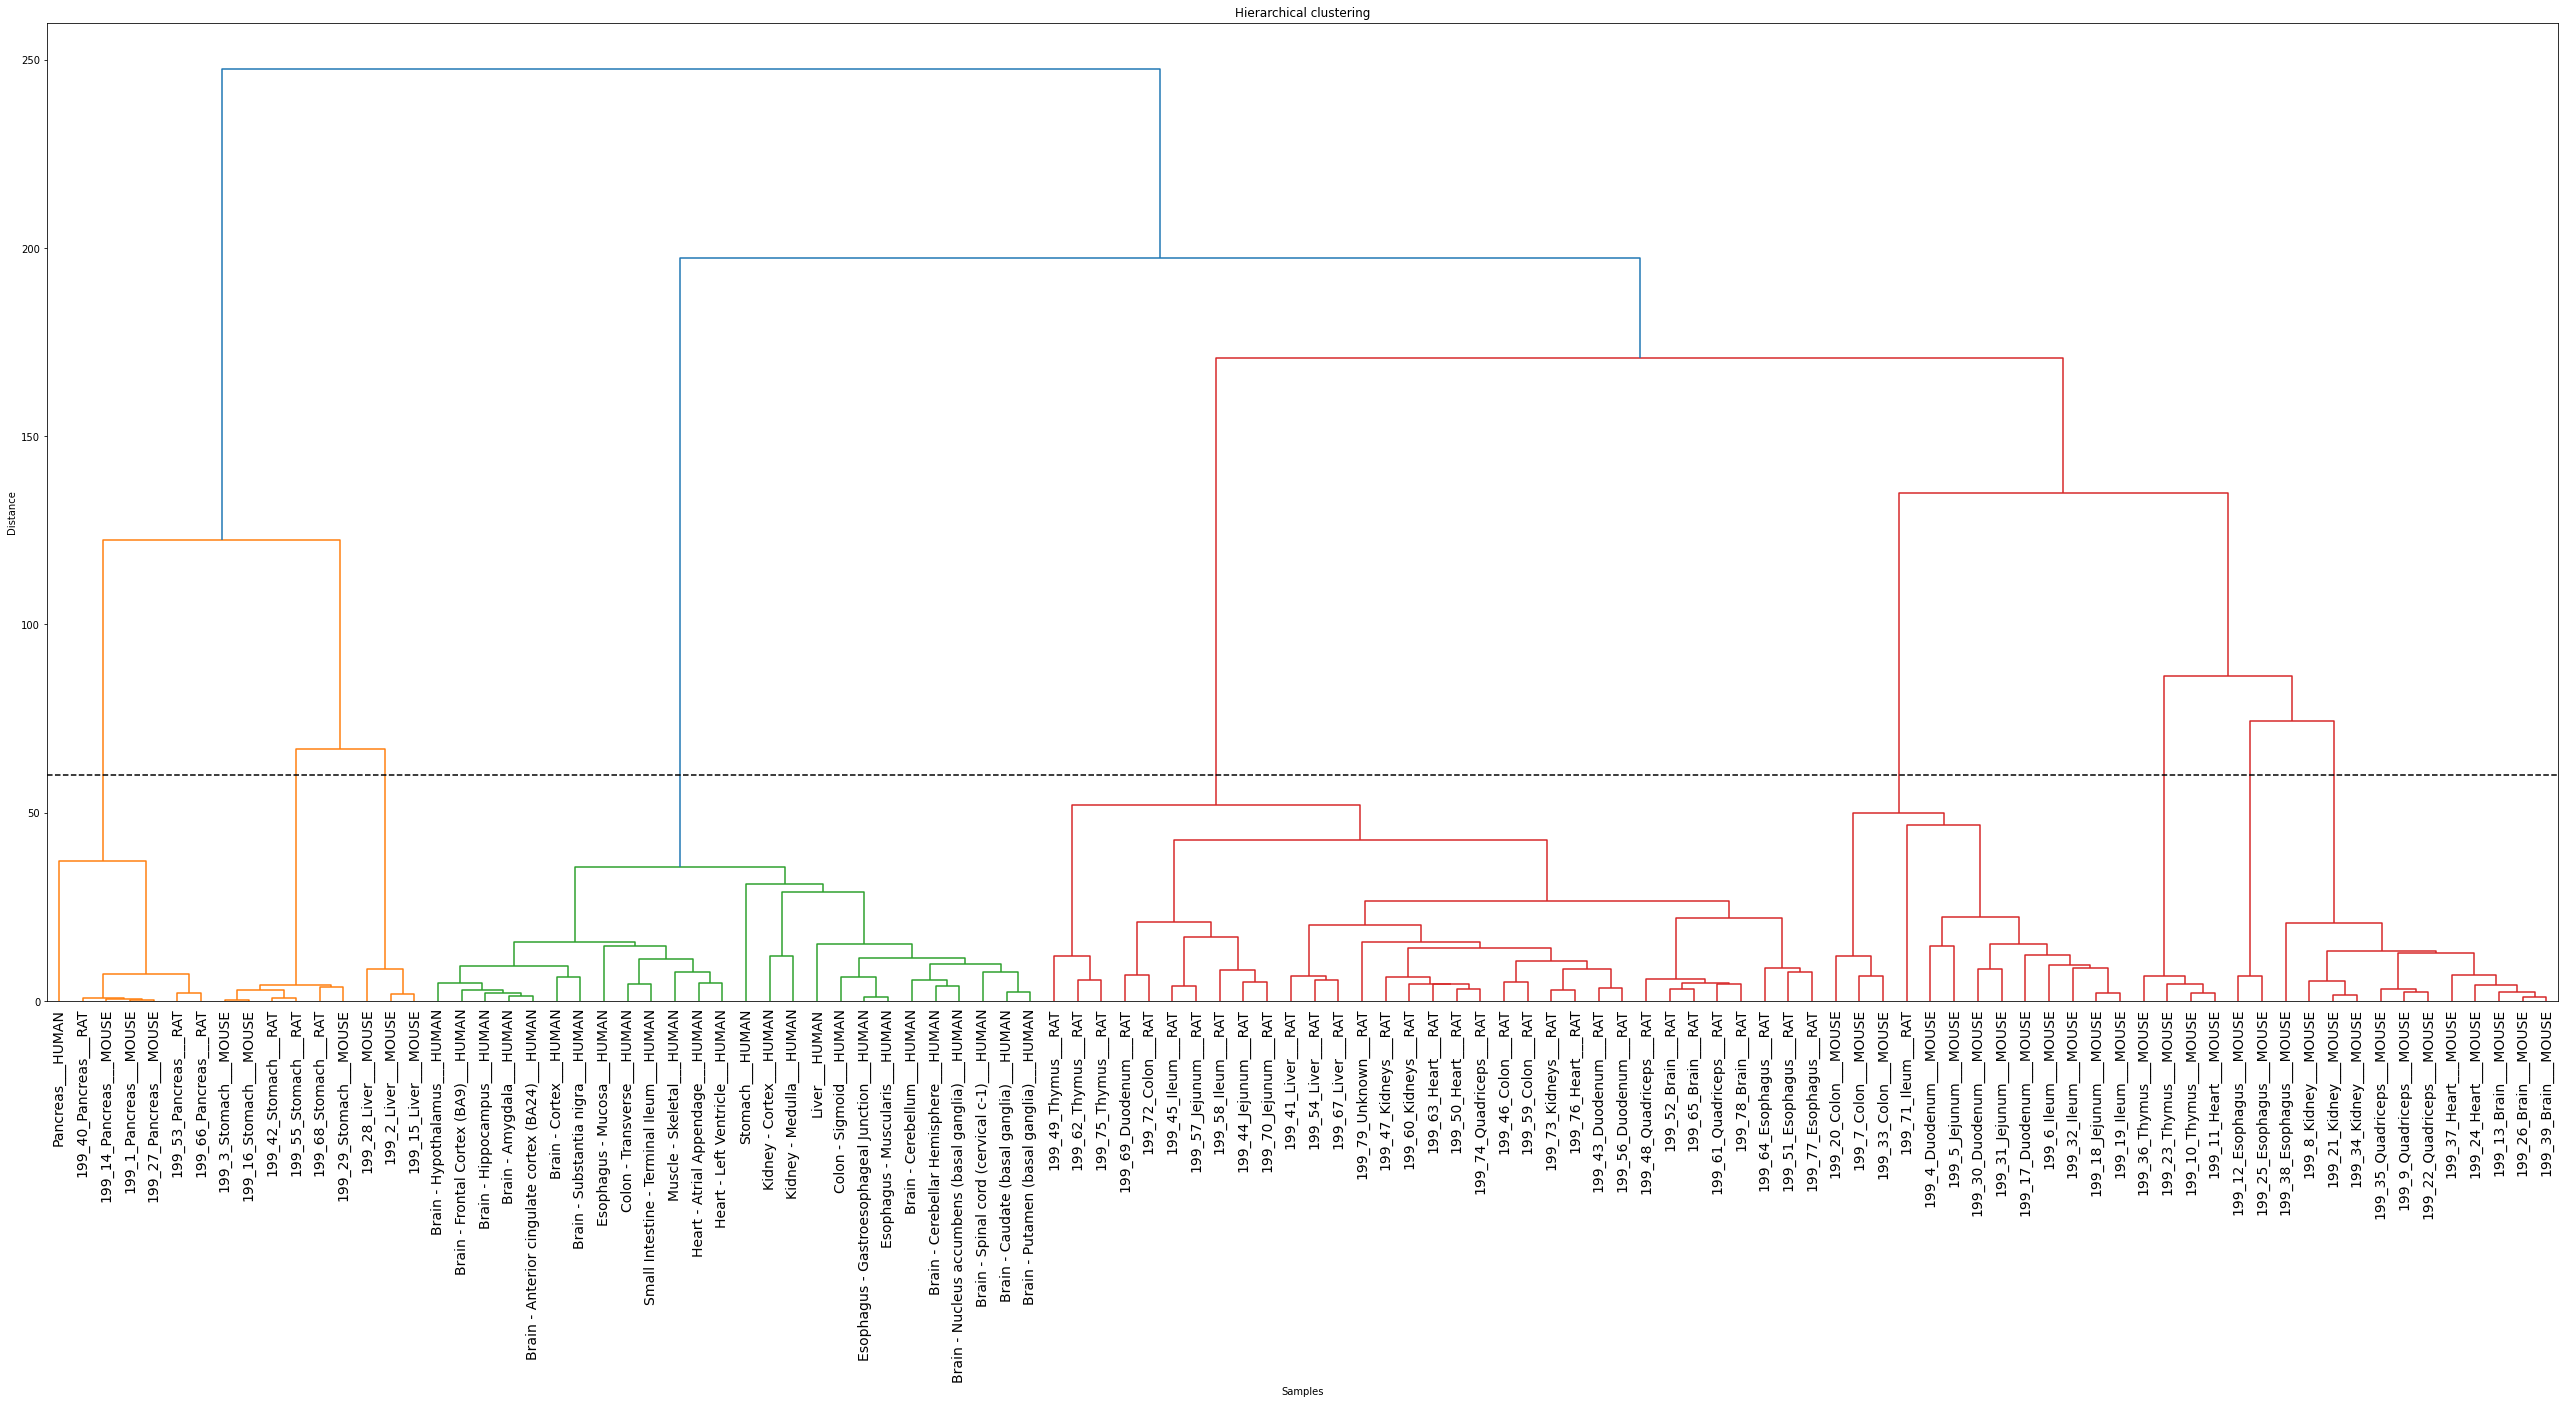

In [ ]:
plt.figure(dpi=300)

Z = linkage(result, method='ward')

# Determine the optimal number of clusters using the dendrogram
plt.figure(figsize=(45, 18))
dendrogram(Z, labels=result.index, leaf_font_size=14)
plt.axhline(y=60, color='black', linestyle='--')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.title('Hierarchical clustering')
plt.show()

    We're drawing the line when the distances get too big.' 
    That's at y = 60. Number of clusers = 9. 

#### Let's assume 7 clusters is appropriate

In [ ]:
N_O_C = 9

# Run k-means with the optimal number of clusters
kmeans = KMeans(n_clusters=N_O_C, random_state=0).fit(result)

# Run hierarchical clustering with the optimal number of clusters
hclustering = AgglomerativeClustering(n_clusters=N_O_C, linkage='ward').fit(result)




In [ ]:
# Add the cluster labels to the original dataframe
result['kmeans_cluster'] = kmeans.labels_
# kmeans_test_list = kmeans.labels_

result['hierarchical_cluster'] = hclustering.labels_
# hc_test_list = hclustering.labels_

### Compare the clustering results using both methodologies, and with the tissues/species. Show the results of the final partitions as a table.

In [ ]:
# Calculate the number of tissues in each cluster for both algorithms
kmeans_tissue_counts = result.groupby([result.index.str.split('___').str[1], 'kmeans_cluster']).size().reset_index(name='count')
hierarchical_tissue_counts = result.groupby([result.index.str.split('___').str[1], 'hierarchical_cluster']).size().reset_index(name='count')

# Print the results as tables
print('K-means clustering results:')
display(kmeans_tissue_counts.T)
print('\nHierarchical clustering results:')
display(hierarchical_tissue_counts.T)


K-means clustering results:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
level_0,HUMAN,HUMAN,MOUSE,MOUSE,MOUSE,MOUSE,MOUSE,MOUSE,MOUSE,RAT,RAT,RAT,RAT,RAT
kmeans_cluster,1,4,0,2,4,5,6,7,8,0,2,3,4,7
count,26,1,12,3,3,12,3,4,2,1,3,32,3,1



Hierarchical clustering results:


,0,1,2,3,4,5,6,7,8,9,10,11,12
level_0,HUMAN,HUMAN,MOUSE,MOUSE,MOUSE,MOUSE,MOUSE,MOUSE,MOUSE,RAT,RAT,RAT,RAT
hierarchical_cluster,2,5,1,2,3,4,6,7,8,0,1,2,8
count,1,26,12,3,12,3,4,2,3,33,1,3,3


In [ ]:
result = result.T

In [ ]:
rez = result.T.drop(columns=['hierarchical_cluster','kmeans_cluster'])
rez = rez.T
rez.drop_duplicates(inplace=True)
rez = rez[~rez.index.duplicated(keep='first')]

### Plot a heatmap of the 50 genes with top variance over all samples. Add the information about tissue groups and model (human, rat and mouse) as annotations in the heatmap*.

In [ ]:
# Calculate the variance of each gene across all samples
gene_variances = rez.var(axis=1)

# Get the indices of the 50 genes with the highest variance
top_variances = gene_variances.nlargest(50).index

# Get a subset of the data with only the top 50 genes
result_top_variances = rez.loc[top_variances]


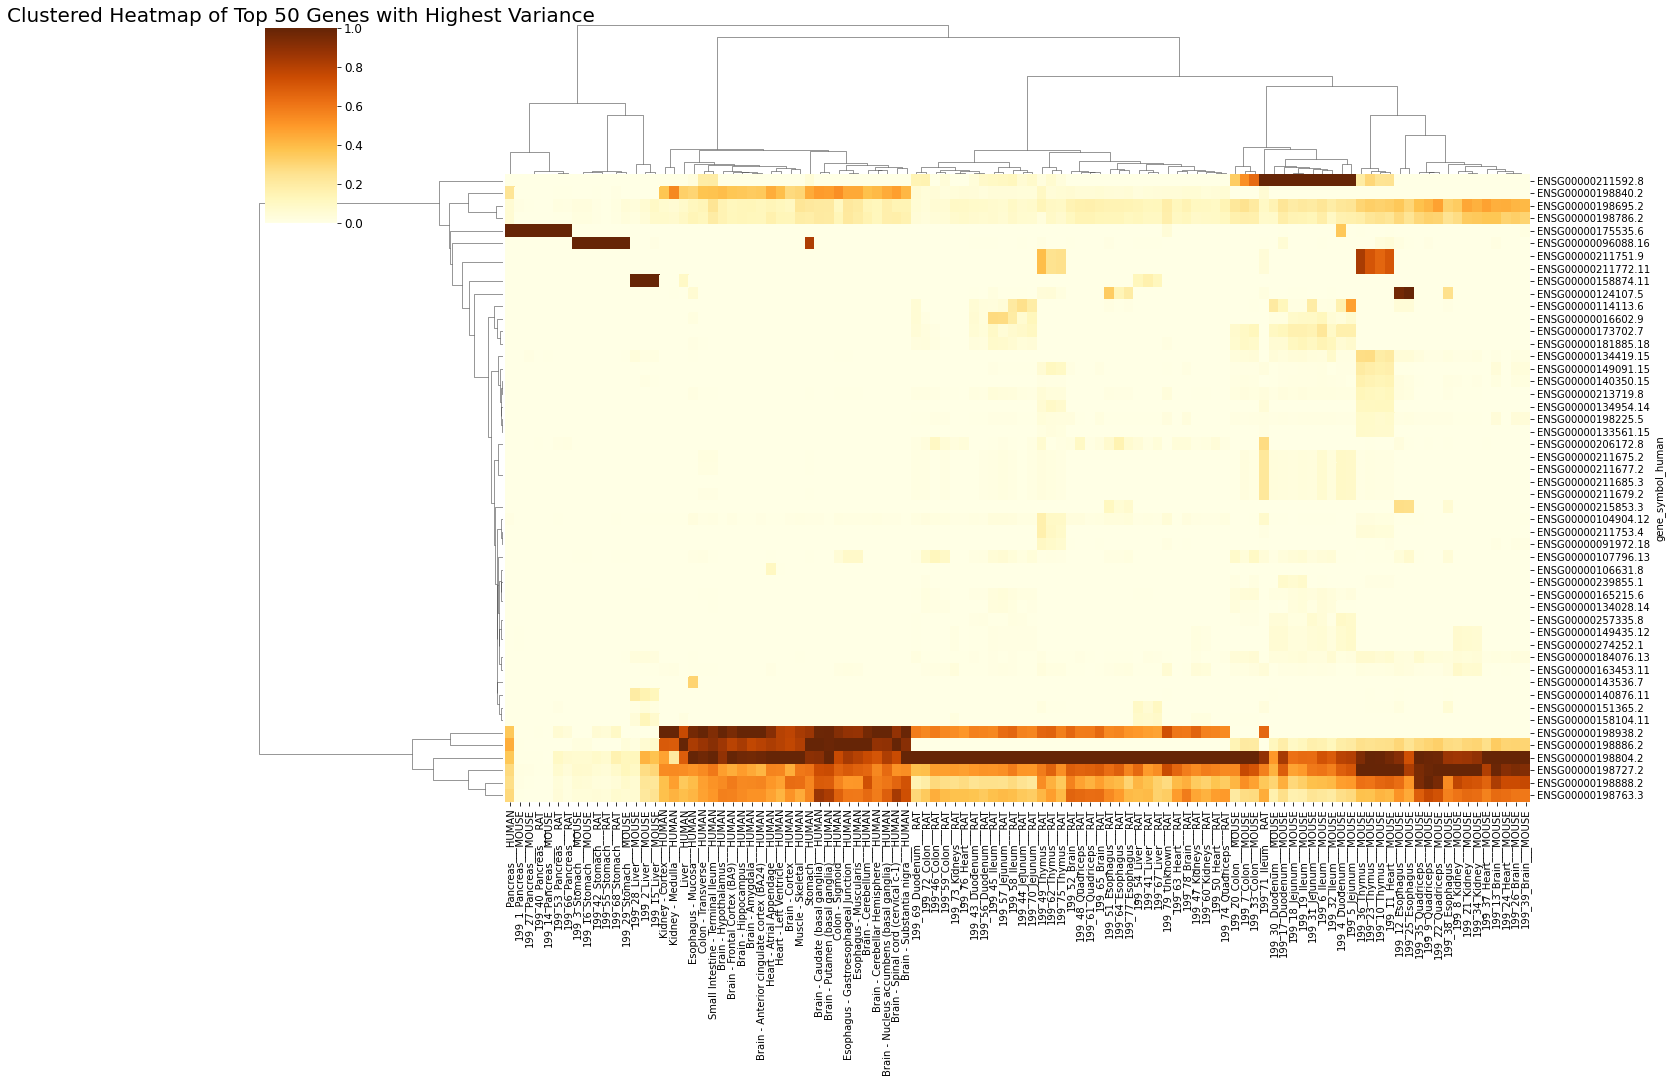

In [ ]:
sns.clustermap(result_top_variances, cmap='YlOrBr', standard_scale=1, figsize=(20, 15),
               xticklabels=True, yticklabels=True, dendrogram_ratio=0.2, method='ward')

# Set the axis labels and title
plt.title('Clustered Heatmap of Top 50 Genes with Highest Variance', fontsize=20)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

# Exercise 2

## PCA

### With the gene expression for different tissues and models, perform a PCA on the data and visualize the results (PC1 and PC2, and also, PC3 ). Label the points in the plot with their respective tissues/models.

In [ ]:
colors = []
for col_name in result.columns:
    if col_name.endswith('___HUMAN'):
        colors.append('red')
    elif col_name.endswith('___RAT'):
        colors.append('blue')
    elif col_name.endswith('___MOUSE'):
        colors.append('green')

handles = [Patch(facecolor='red', label='Human'),
           Patch(facecolor='blue', label='Rat'),
           Patch(facecolor='green', label='Mouse')]


In [ ]:
# Perform PCA on the data
pca = PCA(n_components=3)
pca.fit(result.T)
result_pca = pca.transform(result.T)

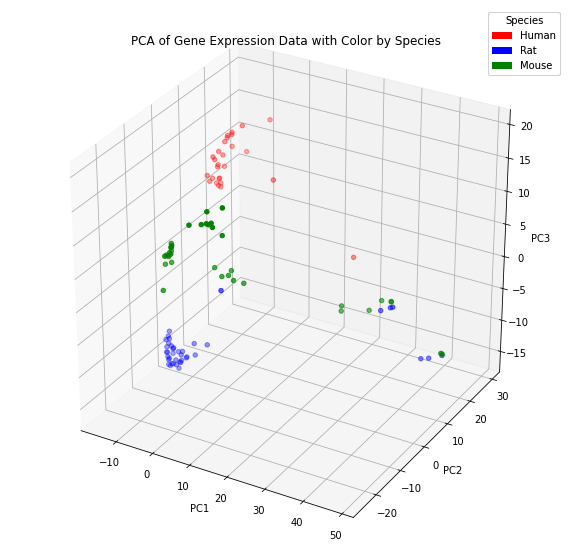

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(result_pca[:, 0], result_pca[:, 1], result_pca[:, 2], c=colors)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA of Gene Expression Data with Color by Species')
legend1 = ax.legend(handles=handles, title='Species', loc='upper right')
ax.add_artist(legend1)
plt.show()

    When visualizing the results of the PCA, we can see that the three species separated fairly well. 
    We can separate the groups fairly well using these three components.

    The main oddity would be that there seems to be a bunch of the results with some heavy overlapping on the right side of the 
    plot, where rat and mouse points seem to mix together.

### Visualize the data using the PC1 and PC2 again, but this time, color the observations by cluster, using the k means clusters, with k of your choice. Produce a caption for the plot

In [ ]:
# Perform PCA on the data
pca = PCA(n_components=3)
pca.fit(result.T)
result_pca = pca.transform(result.T)

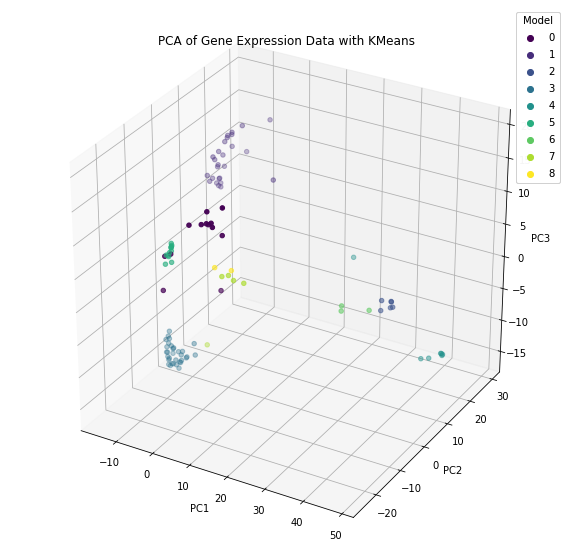

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(result_pca[:, 0], result_pca[:, 1], result_pca[:, 2], c=result.T.kmeans_cluster, cmap='viridis')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA of Gene Expression Data with KMeans')
legend1 = ax.legend(*scatter.legend_elements(), title='Model')
ax.add_artist(legend1)
plt.show()

    When we do the coloring using KMeans, we see that the 9 groups are fairly well separated. 
    Even though there seems to be some overlapping with cluster 5 and some of cluster 0.

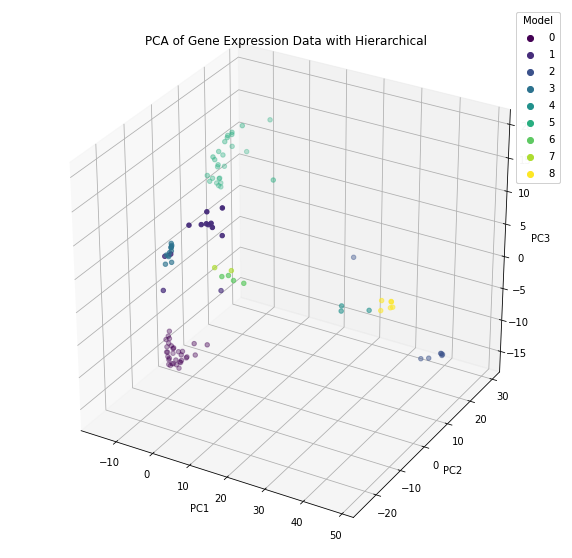

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(result_pca[:, 0], result_pca[:, 1], result_pca[:, 2], c=result.T.hierarchical_cluster, cmap='viridis')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA of Gene Expression Data with Hierarchical')
legend1 = ax.legend(*scatter.legend_elements(), title='Model')
ax.add_artist(legend1)
plt.show()

    We get the same results. There doesn't seem to be any significant difference between hierarchical clustering and kmeans.

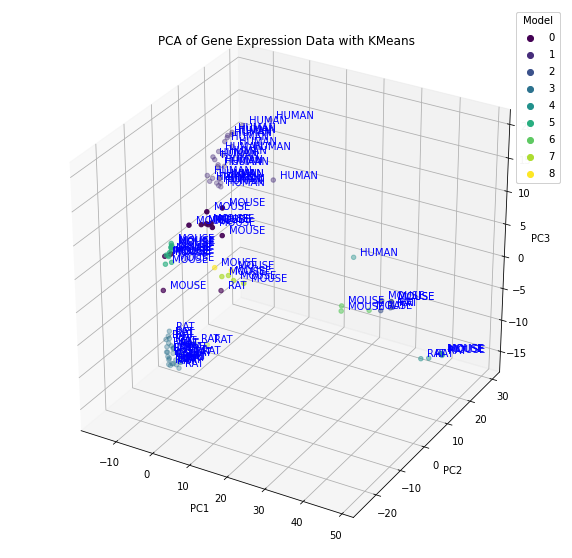

In [ ]:
tissue_model_info = result.columns.str.split('___')
tissue_info = [x[0] for x in tissue_model_info]
model_info = [x[1] for x in tissue_model_info]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(result_pca[:, 0], result_pca[:, 1], result_pca[:, 2], c=result.T.kmeans_cluster, cmap='viridis')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA of Gene Expression Data with KMeans')
legend1 = ax.legend(*scatter.legend_elements(), title='Model')
ax.add_artist(legend1)


# Add labels for each point with offset
for i in range(result_pca.shape[0]):
    tissue = tissue_info[i]
    model = model_info[i]
    ax.text(result_pca[i, 0]+1.05, result_pca[i, 1]+1.05, result_pca[i, 2]+0.05, f'{model}', color='blue')
    # ax.text(result_pca[i, 0]+1.05, result_pca[i, 1]+1.05, result_pca[i, 2]+0.05, f'{tissue}\n{model}', color='black')


plt.show()


    This shows pretty well that the species are indeed grouping together. Except for the group on the right. 
    This is another way to see the same plot we saw previously, it just has the added labels.

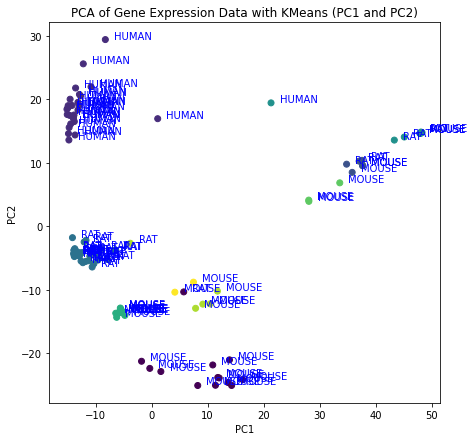

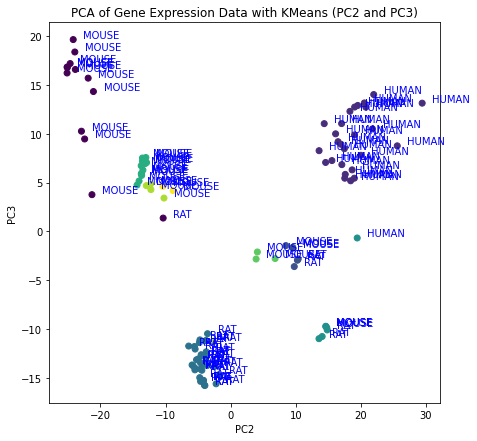

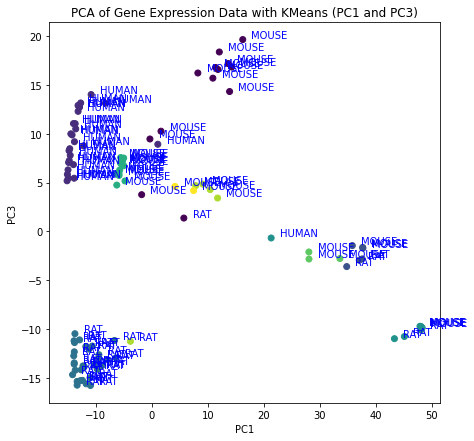

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
scatter = ax.scatter(result_pca[:, 0], result_pca[:, 1], c=result.T.kmeans_cluster, cmap='viridis')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA of Gene Expression Data with KMeans (PC1 and PC2)')

# Add labels for each point with offset
for i in range(result_pca.shape[0]):
    tissue = tissue_info[i]
    model = model_info[i]
    ax.text(result_pca[i, 0]+1.55, result_pca[i, 1]+0.15, f'{model}', color='blue')

plt.show()

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
scatter = ax.scatter(result_pca[:, 1], result_pca[:, 2], c=result.T.kmeans_cluster, cmap='viridis')
ax.set_xlabel('PC2')
ax.set_ylabel('PC3')
ax.set_title('PCA of Gene Expression Data with KMeans (PC2 and PC3)')

# Add labels for each point with offset
for i in range(result_pca.shape[0]):
    tissue = tissue_info[i]
    model = model_info[i]
    ax.text(result_pca[i, 1]+1.55, result_pca[i, 2]+0.15, f'{model}', color='blue')

plt.show()


fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
scatter = ax.scatter(result_pca[:, 0], result_pca[:, 2], c=result.T.kmeans_cluster, cmap='viridis')
ax.set_xlabel('PC1')
ax.set_ylabel('PC3')
ax.set_title('PCA of Gene Expression Data with KMeans (PC1 and PC3)')

# Add labels for each point with offset
for i in range(result_pca.shape[0]):
    tissue = tissue_info[i]
    model = model_info[i]
    ax.text(result_pca[i, 0]+1.55, result_pca[i, 2]+0.15, f'{model}', color='blue')

plt.show()



When looking at these plots we could say that:
- PC1: separates human and rat data from mouse data.
- PC2: separates most of the groups from each other.
- PC3: separates human and mouse from rat.

### What are the top 50 genes that contribute to the PC1? Are they the same genes that are more variable according to the exercise 1?

In [ ]:
result = result.T.drop(columns=['hierarchical_cluster','kmeans_cluster'])

In [ ]:
pca = PCA(n_components=2)
pca.fit(result)
result_pca = pca.transform(result)

In [ ]:
# Get the loadings of the first principal component
loadings_pc1 = pca.components_[0]

# Get the indices of the top 50 genes that contribute to PC1
top_genes_pc1 = np.argsort(np.abs(loadings_pc1))[::-1][:74]
                                                      # this later becomes 50

In [ ]:
# Get the names of the top 50 genes
gene_names_pc1 = result.columns[top_genes_pc1]

In [ ]:
# Get a subset of the data with only the top 50 genes
result_top_variances = rez.loc[list(set(gene_names_pc1))]

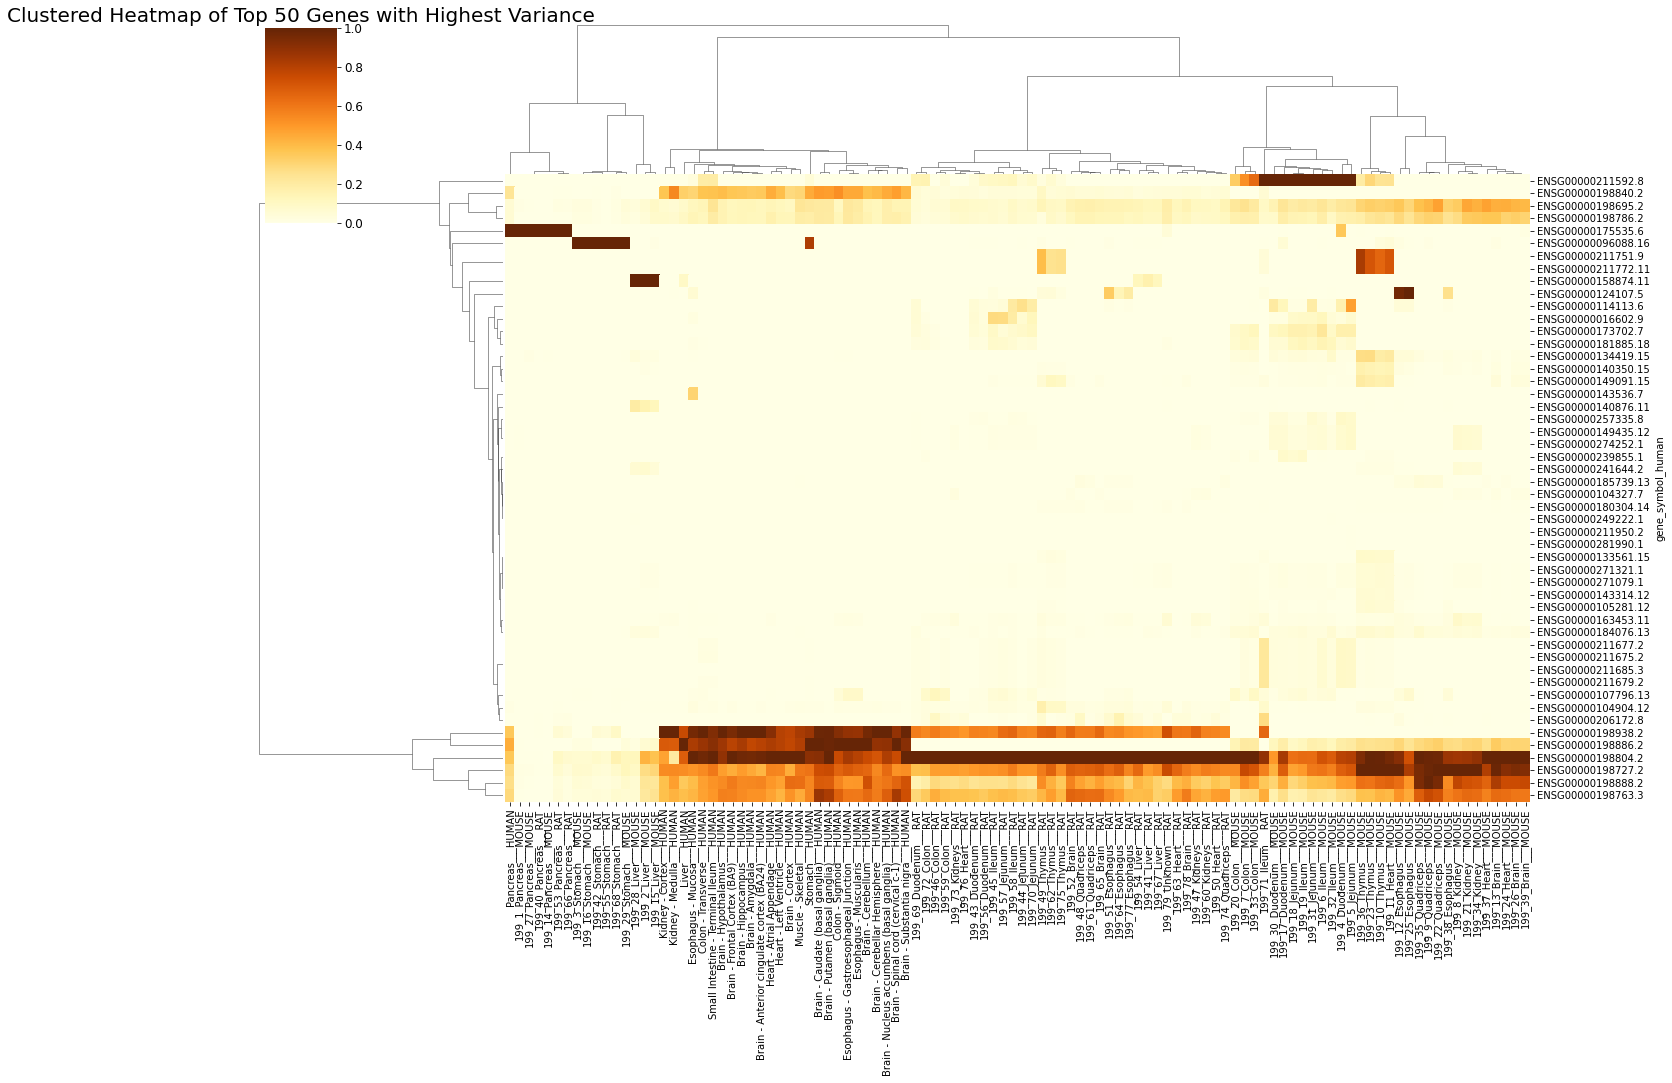

In [ ]:
sns.clustermap(result_top_variances, cmap='YlOrBr', standard_scale=1, figsize=(20, 15),
               xticklabels=True, yticklabels=True, dendrogram_ratio=0.2, method='ward')

# Set the axis labels and title
plt.title('Clustered Heatmap of Top 50 Genes with Highest Variance', fontsize=20)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

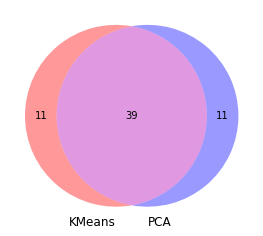


KMeans unique:
1.	ENSG00000158104.11
2.	ENSG00000211753.4
3.	ENSG00000215853.3
4.	ENSG00000165215.6
5.	ENSG00000106631.8
6.	ENSG00000091972.18
7.	ENSG00000198225.5
8.	ENSG00000134028.14
9.	ENSG00000134954.14
10.	ENSG00000213719.8
11.	ENSG00000151365.2

PC1 unique:
1.	ENSG00000281990.1
2.	ENSG00000249222.1
3.	ENSG00000271079.1
4.	ENSG00000180304.14
5.	ENSG00000241644.2
6.	ENSG00000185739.13
7.	ENSG00000271321.1
8.	ENSG00000143314.12
9.	ENSG00000211950.2
10.	ENSG00000104327.7
11.	ENSG00000105281.12

Intersect:
1.	ENSG00000134419.15
2.	ENSG00000140876.11
3.	ENSG00000198888.2
4.	ENSG00000140350.15
5.	ENSG00000211685.3
6.	ENSG00000173702.7
7.	ENSG00000104904.12
8.	ENSG00000133561.15
9.	ENSG00000096088.16
10.	ENSG00000257335.8
11.	ENSG00000239855.1
12.	ENSG00000163453.11
13.	ENSG00000181885.18
14.	ENSG00000211751.9
15.	ENSG00000175535.6
16.	ENSG00000206172.8
17.	ENSG00000107796.13
18.	ENSG00000016602.9
19.	ENSG00000184076.13
20.	ENSG00000211677.2
21.	ENSG00000211772.11
22.	ENSG00000114113.6

In [ ]:
venn2([set(top_variances), set(gene_names_pc1)], set_colors=('red', 'blue'), set_labels=('KMeans', 'PCA'))
plt.show()

km_set = set(top_variances) - set(gene_names_pc1)
pc1_set = set(gene_names_pc1) - set(top_variances)
inter_set = set(top_variances).intersection(set(gene_names_pc1))

print("\nKMeans unique:")
for x, i in enumerate(km_set):
  print(x+1, '.\t', i, sep='')

print("\nPC1 unique:")
for x, i in enumerate(pc1_set):
  print(x+1, '.\t', i, sep='')

print("\nIntersect:")
for x, i in enumerate(inter_set):
  print(x+1, '.\t', i, sep='')


## tSNE

### Perform t-SNE on the dataset and visualize the results. Test at least 2 perplexity values.

In [ ]:
# Add the cluster labels to the original dataframe
result['kmeans_cluster'] = kmeans.labels_
# kmeans_test_list = kmeans.labels_

result['hierarchical_cluster'] = hclustering.labels_
# hc_test_list = hclustering.labels_

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


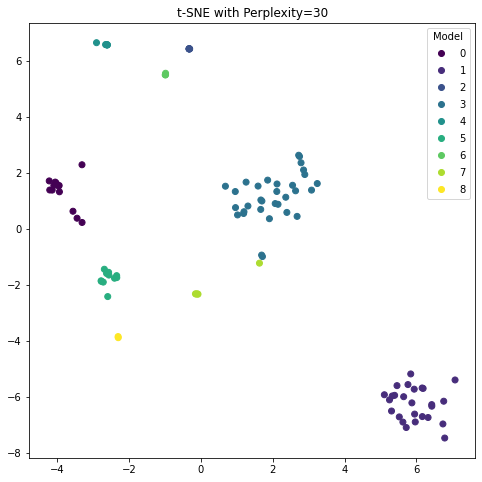

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


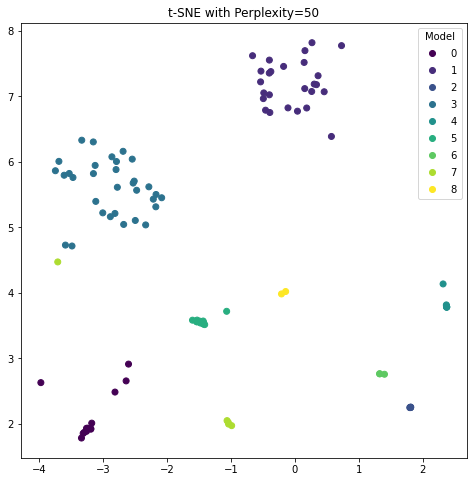

In [ ]:
# Perform t-SNE with perplexity=30
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
result_tsne_30 = tsne.fit_transform(result)

# Plot the results with perplexity=30
plt.figure(figsize=(8, 8))
plt.scatter(result_tsne_30[:, 0], result_tsne_30[:, 1], c=result.kmeans_cluster, cmap='viridis')
plt.title('t-SNE with Perplexity=30')
plt.legend(*scatter.legend_elements(), title='Model', loc='upper right')
plt.show()

# Perform t-SNE with perplexity=50
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
result_tsne_50 = tsne.fit_transform(result)

# Plot the results with perplexity=50
plt.figure(figsize=(8, 8))
plt.scatter(result_tsne_50[:, 0], result_tsne_50[:, 1], c=result.kmeans_cluster, cmap='viridis')
plt.title('t-SNE with Perplexity=50')
plt.legend(*scatter.legend_elements(), title='Model', loc='upper right')
plt.show()

The data shows a clearer separation between different clusters compared to the results obtained with PCA. The impact of perplexity on the results is evident, with higher values yielding more precise results. Perplexity represents the number of nearest neighbors used to compute the similarity between data points in the high-dimensional space (30 in the first one and 50 in the second one), and selecting an appropriate perplexity value is critical to obtain a meaningful embedding that preserves the underlying structure of the data.